In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from constrained_linear_regression import ConstrainedLinearRegression
from sklearn.linear_model import LinearRegression
import copy
from RIS_gravity_inversion import inversion as inv
import pandas as pd
import time
import verde as vd
import numpy as np
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Jacobian, residual, and bounds data

In [3]:
square_jac = np.load("../synthetic_data/square_jacobian.npy")
square_res = np.load("../synthetic_data/square_residual.npy")

print(f" Jacobian shape: {np.shape(square_jac)}")
print(f" Residual shape: {np.shape(square_res)}")

 Jacobian shape: (4941, 4941)
 Residual shape: (4941,)


In [4]:
non_square_jac = np.load("../synthetic_data/non_square_jacobian.npy")
non_square_res = np.load("../synthetic_data/non_square_residual.npy")

print(f" Jacobian shape: {np.shape(non_square_jac)}")
print(f" Residual shape: {np.shape(non_square_res)}")

 Jacobian shape: (1271, 4941)
 Residual shape: (1271,)


In [46]:
prisms =  xr.open_zarr("../synthetic_data/synthetic_starting_prisms.zarr")
prisms["surface"] = xr.where(prisms.density > 0, prisms.top, prisms.bottom)
prisms.load()

<xarray.Dataset>
Dimensions:    (northing: 61, easting: 81)
Coordinates:
    bottom     (northing, easting) float64 -703.3 -703.3 ... -729.8 -732.0
  * easting    (easting) float64 0.0 1e+03 2e+03 3e+03 ... 7.8e+04 7.9e+04 8e+04
  * northing   (northing) float64 0.0 1e+03 2e+03 ... 5.8e+04 5.9e+04 6e+04
    top        (northing, easting) float64 -587.2 -590.2 ... -703.3 -703.3
Data variables:
    density    (northing, easting) int64 1383 1383 1383 ... -1383 -1383 -1383
    min_dist   (northing, easting) float64 6.57e+03 6.307e+03 ... 1.597e+04
    thickness  (northing, easting) float64 116.0 113.0 109.7 ... -26.56 -28.74
    weights    (northing, easting) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    surface    (northing, easting) float64 -587.2 -590.2 ... -729.8 -732.0
Attributes:
    coords_units:      meters
    properties_units:  SI

In [47]:
prisms_df = vd.grid_to_table(prisms)
prisms_df

,northing,easting,density,min_dist,thickness,weights,surface
0,0.0,0.0,1383,6569.680665,116.029069,1.0,-587.222290
1,0.0,1000.0,1383,6307.034891,113.028397,1.0,-590.222961
2,0.0,2000.0,1383,6196.505000,109.683183,1.0,-593.568176
3,0.0,3000.0,1383,6246.171571,106.019120,1.0,-597.232239
4,0.0,4000.0,1383,6452.336351,102.081559,1.0,-601.169800
...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-1383,13889.599850,-19.939193,1.0,-723.190552
4937,60000.0,77000.0,-1383,14332.557140,-22.152694,1.0,-725.404053
4938,60000.0,78000.0,-1383,14829.814710,-24.358932,1.0,-727.610291
4939,60000.0,79000.0,-1383,15376.105311,-26.555465,1.0,-729.806824


# Test various solvers with square data

In [5]:
jacobian = copy.deepcopy(square_jac)
residuals = copy.deepcopy(square_res)

In [6]:
solvers = [
    "verde least squares",
    "scipy least squares",
    # "scipy constrained",
    # "CLR",
    # "scipy conjugate",
    
    "numpy least squares",
    # "steepest descent",
    "gauss newton",
]

In [7]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=None,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

In [14]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i*100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers  
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

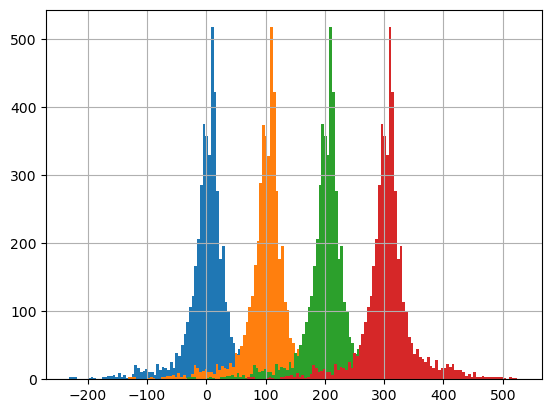

In [15]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

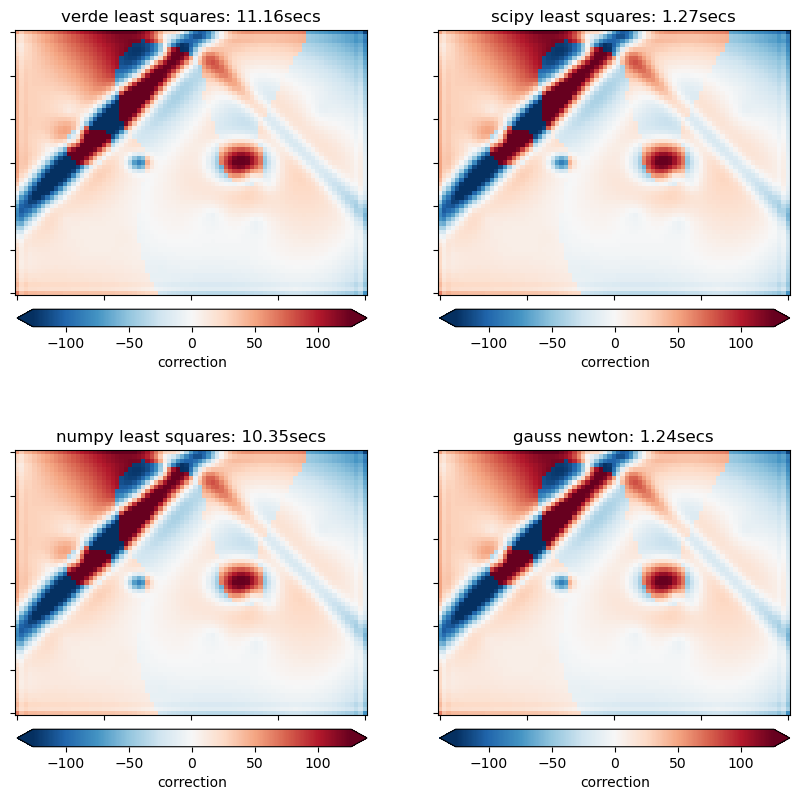

In [32]:
coordinates = vd.grid_coordinates(region=[0, 80, 0, 60], spacing=1)
data = np.ones_like(coordinates[0])
grid = vd.make_xarray_grid(coordinates, data, data_names="dummy")
df = vd.grid_to_table(grid)

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g=0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing","easting"]).to_xarray().correction

        grid.plot(
            ax=ax[i,j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i,j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")
        
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        ax[i,j].set_aspect("equal")
        g +=1 


fig.show()

## with damping

In [56]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=.1,
        surface=prisms_df.surface,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

[1.2985317199490964,
 0.10636906791478395,
 13.615396558307111,
 6.877585175912827]

In [57]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i*100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers  
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

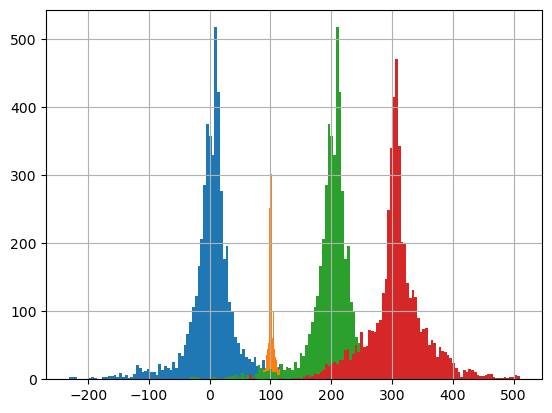

In [58]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

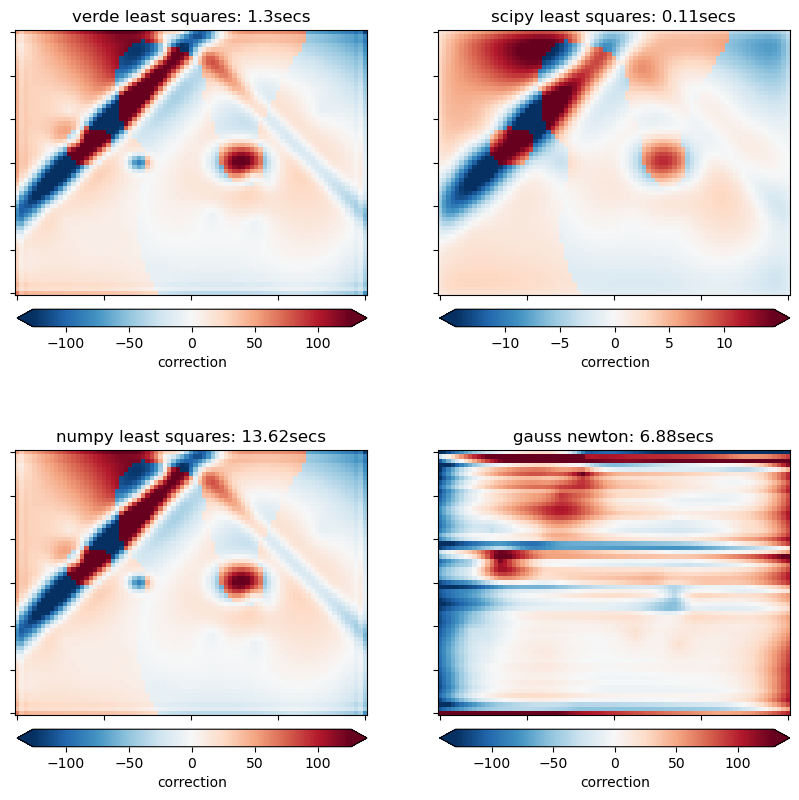

In [59]:
coordinates = vd.grid_coordinates(region=[0, 80, 0, 60], spacing=1)
data = np.ones_like(coordinates[0])
grid = vd.make_xarray_grid(coordinates, data, data_names="dummy")
df = vd.grid_to_table(grid)

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g=0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing","easting"]).to_xarray().correction

        grid.plot(
            ax=ax[i,j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i,j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")
        
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        ax[i,j].set_aspect("equal")
        g +=1 


fig.show()

# Test various solvers with non - square data

In [60]:
jacobian = copy.deepcopy(non_square_jac)
residuals = copy.deepcopy(non_square_res)

In [66]:
solvers = [
    "verde least squares",
    "scipy least squares",
    # "scipy constrained",
    # "CLR",
    # "scipy conjugate",
    
    "numpy least squares",
    # "steepest descent",
    # "gauss newton",
]

In [67]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=None,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/verde/base/least_squares.py:57: UserWarning:

Under-determined problem detected (ndata, nparams)=(1271, 4941).



[1.305920131970197, 0.07501605013385415, 1.8186869979836047]

In [68]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i*100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers  
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

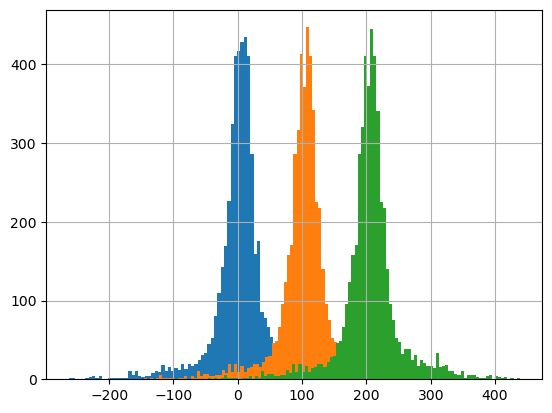

In [69]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

IndexError: list index out of range

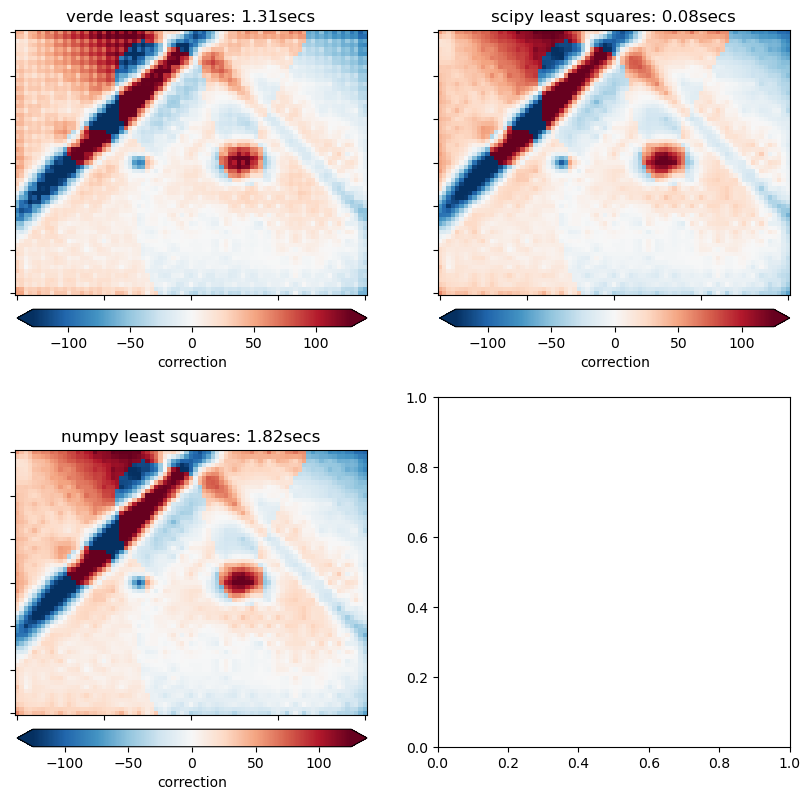

In [70]:
coordinates = vd.grid_coordinates(region=[0, 80, 0, 60], spacing=1)
data = np.ones_like(coordinates[0])
grid = vd.make_xarray_grid(coordinates, data, data_names="dummy")
df = vd.grid_to_table(grid)

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g=0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing","easting"]).to_xarray().correction

        grid.plot(
            ax=ax[i,j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i,j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")
        
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        ax[i,j].set_aspect("equal")
        g +=1 


fig.show()

<Axes: >

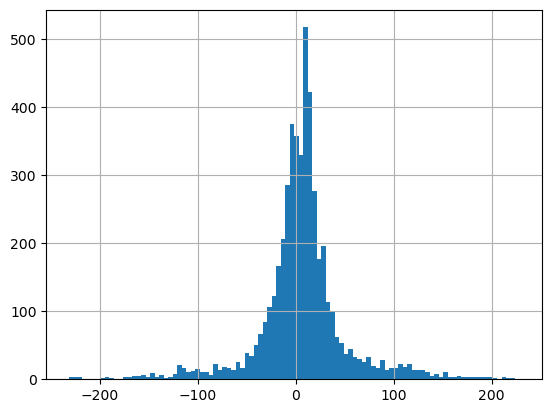

In [ ]:
# Gauss Newton w/ 1st order Tikhonov regularization
jacobian = jacobian.copy()

fdmatrix = inv.finite_difference_matrix(jacobian[1].size)

damping =0

if damping in [None, 0]:
    hessian = jacobian.T @ jacobian
    gradient = jacobian.T @ residuals
else:
    fdmatrix = inv.finite_difference_matrix(jacobian[1].size)
    hessian = (jacobian.T @ jacobian) + damping * (fdmatrix.T @ fdmatrix)
    gradient = (jacobian.T @ residuals) - damping * (
        fdmatrix.T @ fdmatrix @ prisms_df.surface
    )

step = np.linalg.solve(hessian, gradient)
pd.Series(step).hist(bins=100)

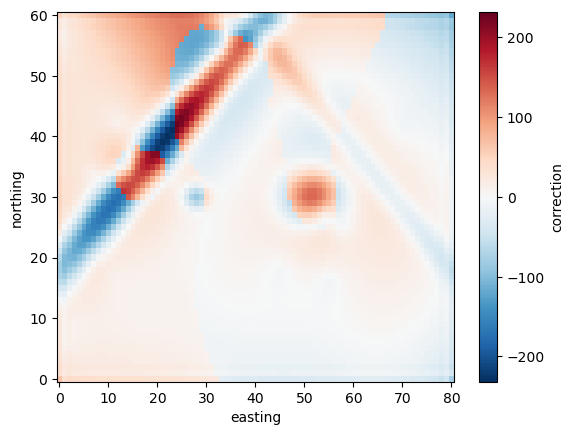

In [53]:
df["correction"] = step
grid = df.set_index(["northing","easting"]).to_xarray().correction
grid.plot()